In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt; t = Okt()
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from wordcloud import WordCloud
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
review_data = pd.read_csv('./서울_강남구.csv')
review_data

,name,score,review
0,명동칼국수샤브샤브 강남대로점,1,설거지좀 제대로 해주세요. 칼국수 그릇 겉에 국물 마른 자국이 항상 있네요
1,명동칼국수샤브샤브 강남대로점,4,맛있음. 구성좋고 가격도 합리적. 친절함.
2,명동칼국수샤브샤브 강남대로점,5,"가성비 좋고, 죽이 맛있어요. 칼국수는 쏘쏘"
3,명동칼국수샤브샤브 강남대로점,5,깔끔존맛이에요
4,명동칼국수샤브샤브 강남대로점,3,NaN
...,...,...,...
27016,류몽민,5,닭갈비에 밥볶아먹는거 너무좋아요 >< 집에서 해먹음 왜 이맛이 안나는지ㅠㅠ 또 찾아...
27017,크랩52,4,NaN
27018,크랩52,5,와이프가 좋아합니다. 와이프가 너무 좋아해서 자주 오고 싶은데 예약이 너무 어려움....
27019,크랩52,5,NaN


In [3]:
review_data.isna().sum()

name         0
score        0
review    4672
dtype: int64

In [4]:
review_data = review_data.dropna(how='any')
review_data.isna().sum()

name      0
score     0
review    0
dtype: int64

In [5]:
review_data

,name,score,review
0,명동칼국수샤브샤브 강남대로점,1,설거지좀 제대로 해주세요. 칼국수 그릇 겉에 국물 마른 자국이 항상 있네요
1,명동칼국수샤브샤브 강남대로점,4,맛있음. 구성좋고 가격도 합리적. 친절함.
2,명동칼국수샤브샤브 강남대로점,5,"가성비 좋고, 죽이 맛있어요. 칼국수는 쏘쏘"
3,명동칼국수샤브샤브 강남대로점,5,깔끔존맛이에요
5,세븐브릭스키친,1,너무 불친절해서 다시는 가고 싶지 않아요.
...,...,...,...
27014,류몽민,5,닭좋아하는 저희 가족 완전 폭식하고 왔어요 넘넘 맛있어요 ㅎㅎㅎ 매운거 못먹겠다는 ...
27015,류몽민,5,닭갈비에 막국수 조합 짱이에요 ㅜㅜ 짱 맛있음.... 다음에 또 올게요 가족들 다 ...
27016,류몽민,5,닭갈비에 밥볶아먹는거 너무좋아요 >< 집에서 해먹음 왜 이맛이 안나는지ㅠㅠ 또 찾아...
27018,크랩52,5,와이프가 좋아합니다. 와이프가 너무 좋아해서 자주 오고 싶은데 예약이 너무 어려움....


In [6]:
review_data['label'] = np.select([review_data.score > 3], [1], default=0)
review_data[:5]

,name,score,review,label
0,명동칼국수샤브샤브 강남대로점,1,설거지좀 제대로 해주세요. 칼국수 그릇 겉에 국물 마른 자국이 항상 있네요,0
1,명동칼국수샤브샤브 강남대로점,4,맛있음. 구성좋고 가격도 합리적. 친절함.,1
2,명동칼국수샤브샤브 강남대로점,5,"가성비 좋고, 죽이 맛있어요. 칼국수는 쏘쏘",1
3,명동칼국수샤브샤브 강남대로점,5,깔끔존맛이에요,1
5,세븐브릭스키친,1,너무 불친절해서 다시는 가고 싶지 않아요.,0


In [7]:
# 고유값 확인
review_data['score'].nunique(), review_data['review'].nunique(), review_data['label'].nunique()

(5, 15303, 2)

In [8]:
# 중복 삭제
review_data.drop_duplicates(subset=['review'], inplace=True)
len(review_data)

15303

In [9]:
review_data.isnull().values.any()

False

In [10]:
# 데이터 분리
train_data, test_data = train_test_split(review_data, test_size = 0.25, random_state = 42)
len(train_data), len(test_data)

(11477, 3826)

<AxesSubplot:>

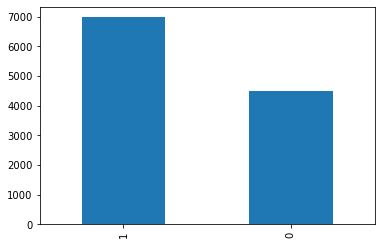

In [11]:
# 데이터 분포
train_data['label'].value_counts().plot(kind = 'bar')

In [12]:
train_data.groupby('label').size().reset_index(name = 'count')

,label,count
0,0,4500
1,1,6977


In [13]:
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['review'].replace('', np.nan, inplace=True)
train_data.isnull().sum()

name       0
score      0
review    53
label      0
dtype: int64

In [14]:
train_data = train_data.dropna(how='any')
train_data.isnull().sum(), len(train_data)

(name      0
 score     0
 review    0
 label     0
 dtype: int64,
 11424)

In [15]:
test_data.drop_duplicates(subset = ['review'], inplace=True)
test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['review'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
test_data.isnull().sum(), len(test_data)

(name      0
 score     0
 review    0
 label     0
 dtype: int64,
 3809)

In [16]:
# 토큰화 검사
t.morphs('정상에 선 기쁨을 다른 사람들과 함께 나누자')

['정상', '에', '선', '기쁨', '을', '다른', '사람', '들', '과', '함께', '나누자']

In [17]:
# 수제 불용어
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [18]:
train_data['tokenized'] = train_data['review'].apply(t.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [19]:
test_data['tokenized'] = test_data['review'].apply(t.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [20]:
# 긍정과 부정에 따른 단어의 빈도수
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [21]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('맛', 1467), ('안', 1050), ('너무', 839), ('직원', 584), ('분', 569), ('에서', 528), ('음식', 527), ('으로', 526), ('하고', 500), ('로', 476), ('가격', 475), ('만', 456), ('그냥', 443), ('요', 427), ('주문', 412), ('별로', 373), ('좀', 361), ('못', 358), ('곳', 357), ('손님', 352)]


In [22]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('맛', 1513), ('너무', 1340), ('맛있어요', 990), ('잘', 651), ('님', 616), ('분위기', 614), ('진짜', 576), ('곳', 546), ('음식', 537), ('최고', 513), ('사장', 508), ('으로', 506), ('가격', 499), ('정말', 475), ('직원', 469), ('에서', 455), ('맛있고', 452), ('로', 446), ('좋아요', 434), ('요', 425)]


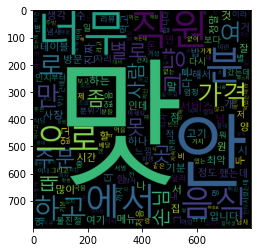

In [23]:
wc = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', width=400, height=400, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(negative_word_count)
plt.figure()
plt.imshow(gen)

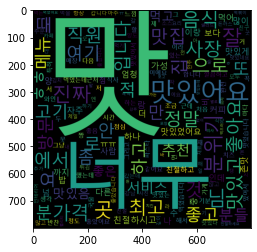

In [24]:
wc = WordCloud(font_path='C:/Windows/Fonts/malgun.ttf', width=400, height=400, scale=2.0, max_font_size=250)
gen = wc.generate_from_frequencies(positive_word_count)
plt.figure()
plt.imshow(gen)

긍정 리뷰의 평균 길이 : 14.978423475258918
부정 리뷰의 평균 길이 : 22.70304114490161


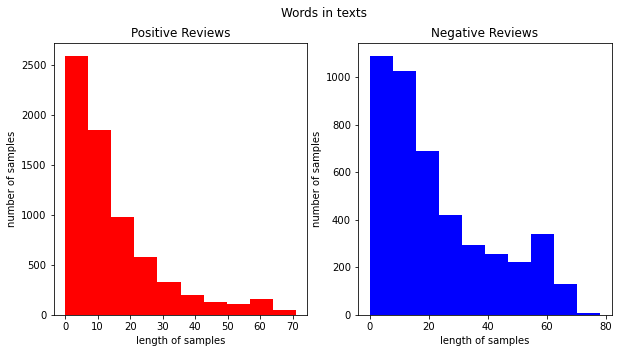

In [25]:
# 긍정과 부정에 따른 길이 분포
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [26]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [28]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 24848
등장 빈도가 1번 이하인 희귀 단어의 수: 13910
단어 집합에서 희귀 단어의 비율: 55.9803605924018
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.763656167034592


In [29]:
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
vocab_size

10940

In [30]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [31]:
print(X_train[:3])

[[20, 41, 185, 41, 325], [3, 2, 230, 326, 13, 3, 89, 1301, 1, 7583], [664, 2798, 145, 5, 1521, 187, 760, 7, 1, 85, 161, 26, 343, 271, 28, 1, 508, 7584, 78, 56, 174, 222, 81, 1803, 1, 3770, 1, 5918, 4924, 30, 1, 861, 28, 14, 1096, 907, 14, 7585, 4, 7585, 564, 1719, 1056, 4925, 1097, 465, 1467, 1897, 533, 272, 71, 5, 29, 606]]


In [32]:
print(X_test[:3])

[[186, 2400, 186, 4589, 1, 1882, 10491, 4897, 4363, 102, 4, 1, 4224, 232, 10307, 7424, 735, 5647, 3445, 1, 4589, 1], [10, 585, 66, 196, 1320, 420, 382, 1467, 217, 1, 332, 410, 14, 5946], [13, 1, 1, 2428, 176, 91, 180, 206, 491, 1051, 1225, 130, 1871, 6009, 814, 128, 1, 491, 1051, 128, 1696, 22, 814, 128, 2, 1065, 936, 1, 686, 3064, 1, 3, 3284, 1, 770, 6472, 609, 178, 4161, 1810, 1960, 1484, 261, 458, 1, 2556, 3842, 261, 235, 2, 230, 178, 8735, 2330]]


리뷰의 최대 길이 : 78
리뷰의 평균 길이 : 18.002275910364144


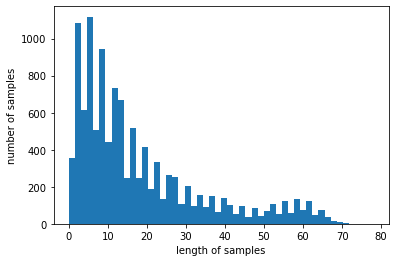

In [33]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [34]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [35]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 100.0


In [36]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [37]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
143/143 [==============================] - ETA: 0s - loss: 0.4499 - acc: 0.7808
Epoch 1: val_acc improved from -inf to 0.85120, saving model to best_model.h5
143/143 [==============================] - 19s 119ms/step - loss: 0.4499 - acc: 0.7808 - val_loss: 0.3429 - val_acc: 0.8512
Epoch 2/15
143/143 [==============================] - ETA: 0s - loss: 0.2744 - acc: 0.8890
Epoch 2: val_acc improved from 0.85120 to 0.86521, saving model to best_model.h5
143/143 [==============================] - 18s 126ms/step - loss: 0.2744 - acc: 0.8890 - val_loss: 0.3254 - val_acc: 0.8652
Epoch 3/15
143/143 [==============================] - ETA: 0s - loss: 0.2115 - acc: 0.9156
Epoch 3: val_acc did not improve from 0.86521
143/143 [==============================] - 17s 121ms/step - loss: 0.2115 - acc: 0.9156 - val_loss: 0.3228 - val_acc: 0.8621
Epoch 4/15
143/143 [==============================] - ETA: 0s - loss: 0.1731 - acc: 0.9311
Epoch 4: val_acc did not improve from 0.86521
143/143 [====

In [38]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

120/120 [==============================] - 2s 15ms/step - loss: 0.3048 - acc: 0.8611

 테스트 정확도: 0.8611


In [39]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = t.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [40]:
sentiment_predict('너무 맛있어서 토했어요')

1/1 [==============================] - 0s 315ms/step
92.03% 확률로 긍정 리뷰입니다.


In [41]:
sentiment_predict('너무 맛있어서 쓰레기통에 잘 넣어 놨어요')

1/1 [==============================] - 0s 23ms/step
97.25% 확률로 긍정 리뷰입니다.


In [42]:
sentiment_predict('이 맛을 혼자만 느낄 수 없어 비둘기한테 줬더니 맛있게 먹었어요')

1/1 [==============================] - 0s 19ms/step
72.89% 확률로 긍정 리뷰입니다.
